Original

In [ ]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "Anwarkh1/Skin_Cancer-Image_Classification"
model = ViTForImageClassification.from_pretrained(model_name).to(device)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

dataset = load_dataset("marmal88/skin_cancer", split="test")

label_map = model.config.label2id

def transform(example):
    image = example["image"]
    image = feature_extractor(image, return_tensors="pt", size=(224, 224))["pixel_values"].squeeze(0)
    label_str = example["dx"]
    label_int = label_map.get(label_str, -1)
    if label_int == -1:
        raise ValueError(f"Unknown label {label_str}")
    return {"pixel_values": image, "dx": torch.tensor(label_int, dtype=torch.long)}

dataset = dataset.map(transform)
dataset.set_format(type="torch", columns=["pixel_values", "dx"])

batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size)

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in dataloader:
        inputs = batch["pixel_values"].to(device)
        labels = batch["dx"].to(device)
        outputs = model(inputs)
        preds = torch.argmax(F.softmax(outputs.logits, dim=1), dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Using device: {device}")
print(f"CUDA Available: {torch.cuda.is_available()}")

accuracy = correct / total
print(f"Evaluation Accuracy: {accuracy:.4f}")

LIME

c:\Users\18903\anaconda3\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


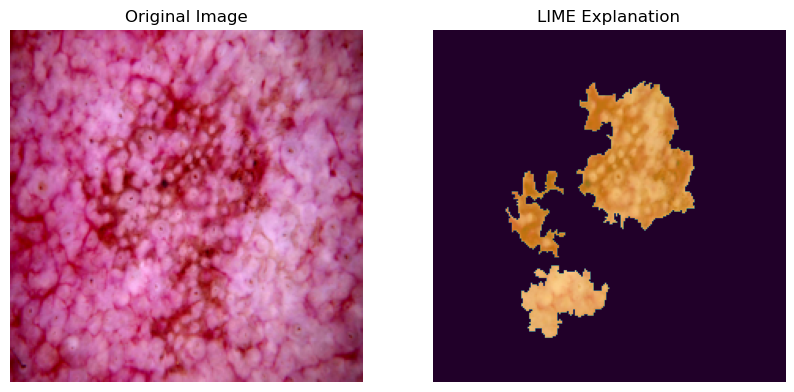

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


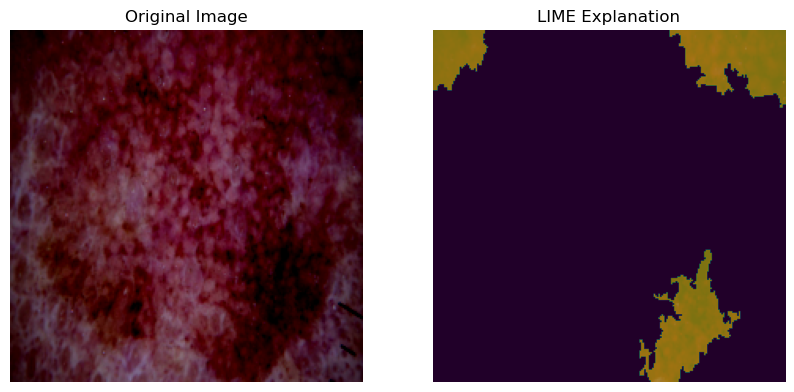

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


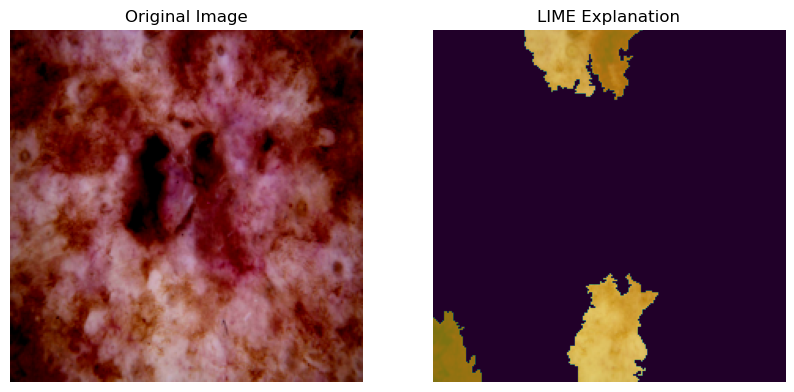

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


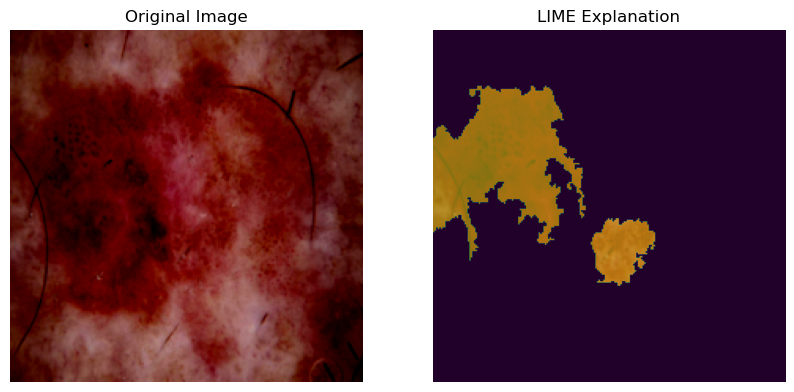

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


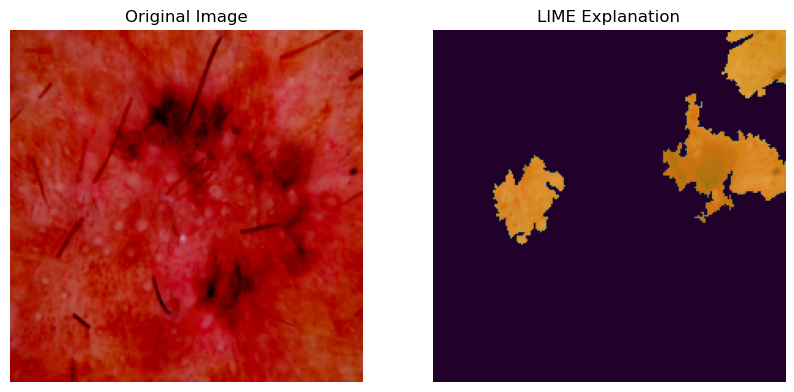

Using device: cuda
CUDA Available: True


In [6]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import slic

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "Anwarkh1/Skin_Cancer-Image_Classification"
model = ViTForImageClassification.from_pretrained(model_name).to(device)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

dataset = load_dataset("marmal88/skin_cancer", split="test")
label_map = model.config.label2id

def transform(example):
    image = example["image"]
    image = feature_extractor(image, return_tensors="pt", size=(224, 224))["pixel_values"].squeeze(0)
    label_str = example["dx"]
    label_int = label_map.get(label_str, -1)
    if label_int == -1:
        raise ValueError(f"Unknown label {label_str}")
    return {"pixel_values": image, "dx": torch.tensor(label_int, dtype=torch.long)}

dataset = dataset.map(transform)
dataset.set_format(type="torch", columns=["pixel_values", "dx"])

def vit_predict(images):
    inputs = feature_extractor(images=[Image.fromarray((img * 255).astype(np.uint8)) for img in images], return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

# Function to generate explanations for multiple images
def generate_lime_explanations(num_images=5):
    for i in range(10,10+num_images):
        sample = dataset[i]
        img = sample["pixel_values"].numpy().transpose(1, 2, 0)
        
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(
            np.array(img), vit_predict, top_labels=5, hide_color=0, num_samples=1000, segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10)
        )
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(img)
        axes[0].set_title("Original Image")
        axes[0].axis("off")
        
        axes[1].imshow(temp)
        axes[1].imshow(mask, alpha=0.5)
        axes[1].set_title("LIME Explanation")
        axes[1].axis("off")
        
        plt.show()

# Generate explanations for a custom number of images
generate_lime_explanations(num_images=5)

print(f"Using device: {device}")
print(f"CUDA Available: {torch.cuda.is_available()}")
